In [ ]:
# Install YOLOv8 from Ultralytics
pip install ultralytics


In [ ]:
import os
import json
import pandas as pd

In [ ]:
det = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_det.tar.gz'

if ('meter_seg' not in os.listdir()):
    for i in [det]:
        !wget $i
        dir_name = i.split('/')[-1]
        !tar -xf $dir_name
else:
    print('Directory already exist')

In [ ]:
import os
import json
import pandas as pd

# Define class mapping (update if you have multiple classes)
class_map = {'meter': 0}

# Function to convert bbox to YOLO format
def convert_bbox_to_yolo(bbox, img_width, img_height):
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return [x_center, y_center, width, height]

# Process annotations for train/test datasets
for name in ['test', 'train']:
    with open(f'meter_det/annotations/instance_{name}.json') as file:
        annotations = json.load(file)

    images = annotations['images']
    annotation = annotations['annotations']

    # Create mapping for image metadata
    img_datas = {i['id']: [i['file_name'], i['width'], i['height']] for i in images}

    # Group bbox annotations by image
    bboxs = {}
    for i in annotation:
        img_id = i['image_id']
        if img_id not in bboxs:
            bboxs[img_id] = [i['bbox']]
        else:
            bboxs[img_id].append(i['bbox'])

    # Generate YOLO-format labels
    for img_id, bboxes in bboxs.items():
        file_name, width, height = img_datas[img_id]
        txt_file_path = f"meter_det/{name}/labels/{os.path.splitext(file_name)[0]}.txt"

        os.makedirs(os.path.dirname(txt_file_path), exist_ok=True)
        with open(txt_file_path, 'w') as label_file:
            for bbox in bboxes:
                yolo_bbox = convert_bbox_to_yolo(bbox, width, height)
                label_file.write(f"{class_map['meter']} " + " ".join(map(str, yolo_bbox)) + "\n")

    print(f"Processed {name} dataset.")


In [ ]:
!yolo task=detect mode=train model=best.pt data=data.yaml epochs=50 imgsz=640

In [ ]:
import os

# Define paths
images_dir = 'meter_det/train/images'  # Update with your images path
labels_dir = 'meter_det/train/labels'  # Update with your labels path

# Validate labels
for image_file in os.listdir(images_dir):
    image_name, _ = os.path.splitext(image_file)
    label_file = f"{image_name}.txt"
    label_path = os.path.join(labels_dir, label_file)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                print(f"Empty label file: {label_path}")
            else:
                print(f"Valid labels found for {image_file}")
    else:
        print(f"Missing label file for {image_file}")

## OCR Confi && yolo

In [ ]:

import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
model = YOLO("Models/model_1_0_2.pt")
reader = easyocr.Reader(['en'])

from typing import Dict, Any
def detect_and_recognize(image_path: str) -> Dict[str, Dict[str, Any]]:
    results = model.predict(source=image_path, conf=0.15, save=False)
    output = {}
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
            # Extract detection info
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
            class_id = int(box.cls)
            class_name = result.names[class_id]
            yolo_conf = box.conf.item()

            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(image_rgb, f"{class_name} {yolo_conf:.2f}",
                        (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            # Process image region
            image = cv2.imread(image_path)
            cropped = image[y_min:y_max, x_min:x_max]
            ocr_results = reader.readtext(cropped)
            ocr_boxes = [detection[0] for detection in ocr_results]
            # _, text, conf = box
            print(result.names[class_id] , box.conf)
            # Print OCR confidence for each detected text
            for detection in ocr_results:
                ocr_text = detection[1]
                ocr_confidence = detection[2]
                print(f"OCR Text: {ocr_text}, Confidence: {ocr_confidence}")


detect_and_recognize('testimg/images/23.jpeg')


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

# Load YOLOv8 model and EasyOCR reader
model = YOLO("Models/model_1_0_2.pt")
reader = easyocr.Reader(['en'])

from typing import Dict, Any

def detect_and_recognize(image_path: str) -> Dict[str, Dict[str, Any]]:
    results = model.predict(source=image_path, conf=0.15, save=False)
    output = {}

    # Load the image to draw bounding boxes
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib

    for result in results:
        for box in result.boxes:
            # Extract detection info
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
            class_id = int(box.cls)
            class_name = result.names[class_id]
            yolo_conf = box.conf.item()  # YOLO confidence

            # Process image region for OCR
            cropped = image[y_min:y_max, x_min:x_max]
            ocr_results = reader.readtext(cropped)
            
            # Draw bounding box on the image
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(image_rgb, f"{class_name} {yolo_conf:.2f}",
                        (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Print YOLO class and confidence
            print(f"YOLO Class: {class_name}, YOLO Confidence: {yolo_conf:.2f}")

            # Process OCR results for each bounding box
            for detection in ocr_results:
                ocr_text = detection[1]
                ocr_confidence = detection[2]
                # Print OCR text and confidence
                print(f"OCR Text: {ocr_text}, OCR Confidence: {ocr_confidence:.2f}")

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

    return output

# Test the function
detect_and_recognize('testimg/images/1.png')


## Custom OCR Model 

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  
model.train(data='data.yaml', epochs=50, imgsz=640)


In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load your trained YOLOv8 model
model = YOLO("Models/ocr-best.pt")

def detect_and_sort_digits(image_path, show_bboxes=True, gap_multiplier=1.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image)

    # Extract bounding boxes
    bboxes = []
    boxes = results[0].boxes
    for box, conf, cls in zip(boxes.xyxy, boxes.conf, boxes.cls):
        x_min = int(box[0].item())
        y_min = int(box[1].item())
        x_max = int(box[2].item())
        y_max = int(box[3].item())
        confidence = float(conf.item())
        class_id = int(cls.item())
        if class_id != 10:  # Assuming class 10 is dot ('.')
            bboxes.append([x_min, y_min, x_max, y_max, confidence, class_id])

    # Print the class labels (IDs) and bounding boxes
    print("Detected Bboxes with Class IDs and Confidence:")
    for bbox in bboxes:
        print(f"Class ID: {bbox[5]}, Bbox: {bbox[:4]}, Confidence: {bbox[4]:.2f}")
    
    if show_bboxes:
        for bbox in bboxes:
            x_min, y_min, x_max, y_max, conf, label = bbox
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image_rgb, 
                        f"{label} ({conf:.2f})",
                        (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.7, 
                        (0, 255, 0), 
                        2)

        plt.figure(figsize=(10, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    digit_sequence = sort_and_extract_digits(bboxes, gap_multiplier)
    
    return digit_sequence

def sort_and_extract_digits(bboxes, gap_multiplier=1.5):
    if not bboxes:
        return ""
    
    # Sort by horizontal position
    sorted_bboxes = sorted(bboxes, key=lambda b: (b[0] + b[2])/2)
    avg_width = sum(b[2]-b[0] for b in sorted_bboxes)/len(sorted_bboxes)
    gap_threshold = avg_width * gap_multiplier
    
    # Group digits based on x-axis gaps
    groups = []
    current_group = [sorted_bboxes[0]]
    
    for bbox in sorted_bboxes[1:]:
        last_bbox = current_group[-1]
        gap = bbox[0] - last_bbox[2] 
        
        if gap > gap_threshold:
            groups.append(current_group)
            current_group = [bbox]
        else:
            current_group.append(bbox)
    
    groups.append(current_group)  
    return " ".join(["".join(str(b[5]) for b in group) for group in groups])

# Test with an example
image_path = 'testimg/ok/7.jpg'
result = detect_and_sort_digits(image_path, gap_multiplier=1.5)
print(f"Formatted Number: {result}")


## test images

testimg/Analog/1 (1).jpeg


image 1/1 c:\Users\soura\Downloads\ML-Model\cropped_images\frame_0305.png_crop_0.png: 544x640 153.1ms
Speed: 5.0ms preprocess, 153.1ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)


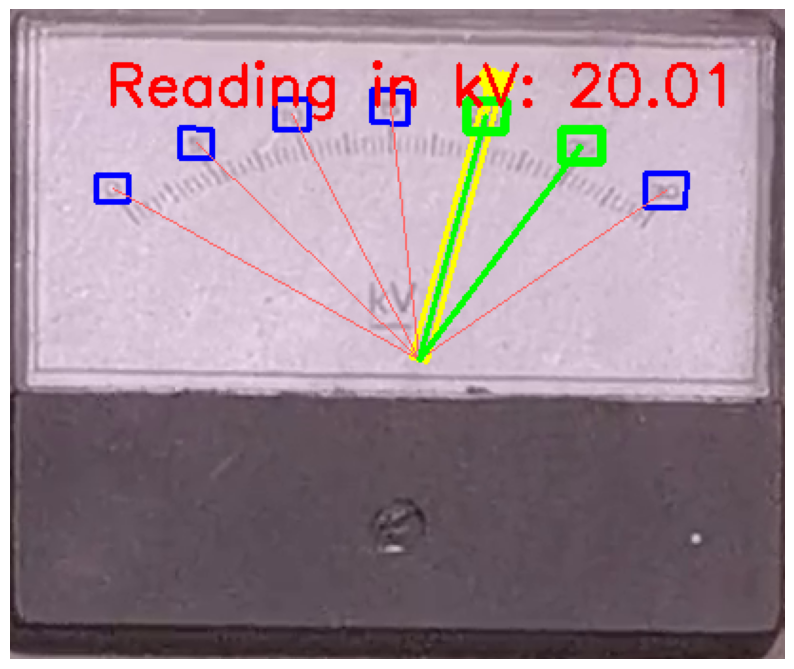

Meter reading in kV: 20.01


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO("Models/analog_reading_v2.pt")

def get_meter_reading(image_path, model):
    results = model(image_path, conf=0.2)
    obb_data = results[0].obb
    class_names = results[0].names

    if obb_data is None:
        return "No objects detected"

    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    number_positions = []
    needle_corners = None
    number_values = [0, 5, 10, 15, 20, 25, 30]
    
    # Extract corners for needle and numbers
    for i, class_id in enumerate(obb_data.cls.cpu().numpy()):
        class_name = class_names[int(class_id)]
        if hasattr(obb_data, "xyxyxyxy") and obb_data.xyxyxyxy is not None:
            corners_flat = obb_data.xyxyxyxy.cpu().numpy()[i]
            corners = np.array(corners_flat).reshape(4, 2)
            
            if class_name.lower() == "needle":
                needle_corners = corners
                # Draw bounding box for needle
                cv2.polylines(image, [corners.astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=2)
                
                # Show needle tip coordinates
                for j in [2, 3]:  # corners 3 and 4 (index 2 and 3)
                    corner = corners[j]
                    cv2.circle(image, (int(corner[0]), int(corner[1])), 6, (0, 255, 255), -1)
                    
            elif class_name.lower() == "numbers":
                # Calculate center point for sorting
                center_x = np.mean(corners[:, 0])
                center_y = np.mean(corners[:, 1])
                number_positions.append((corners, center_x, center_y))
                # Draw bounding box for number
                cv2.polylines(image, [corners.astype(np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)
    
    # Sort number positions from left to right
    number_positions.sort(key=lambda x: x[1])
    meter_center_x = w // 2
    meter_center_y = int(h * 0.8)  # Assuming pivot is near bottom of image
    
    # Try to improve center estimation by analyzing needle position
    if needle_corners is not None:
        # Use the bottom center between corners 0 and 1 of the needle as pivot estimation
        bottom_center_x = (needle_corners[0][0] + needle_corners[1][0]) / 2
        bottom_center_y = (needle_corners[0][1] + needle_corners[1][1]) / 2
        meter_center_x = int(bottom_center_x)
        meter_center_y = int(bottom_center_y)
    
    # Assign values and calculate angles from meter center
    labeled_numbers = []
    for i, (corners, center_x, center_y) in enumerate(number_positions):
        if i < len(number_values):
            value = number_values[i]
            
            # Calculate angle from meter center to number center
            dx = center_x - meter_center_x
            dy = center_y - meter_center_y
            angle = np.degrees(np.arctan2(dy, dx))
            # Adjust angle to 0-360 range
            if angle < 0:
                angle += 360
                
            labeled_numbers.append((corners, value, center_x, center_y, angle))
            
            # Draw line from center to number
            cv2.line(image, (meter_center_x, meter_center_y), (int(center_x), int(center_y)), 
                     (100, 100, 255), 1)
    
    # Sort labeled_numbers by angle for proper interpolation
    labeled_numbers.sort(key=lambda x: x[4])
    
    # Get needle angle and position
    interpolated_value = None
    if needle_corners is not None and labeled_numbers:
        # Calculate needle tip position (midpoint of corners 3 and 4)
        needle_tip_x = (needle_corners[2][0] + needle_corners[3][0]) / 2
        needle_tip_y = (needle_corners[2][1] + needle_corners[3][1]) / 2
        
        # Calculate needle angle from meter center to needle tip
        dx = needle_tip_x - meter_center_x
        dy = needle_tip_y - meter_center_y
        needle_angle = np.degrees(np.arctan2(dy, dx))
        # Adjust angle to 0-360 range
        if needle_angle < 0:
            needle_angle += 360
            
        # Draw needle line
        cv2.line(image, (meter_center_x, meter_center_y), 
                 (int(needle_tip_x), int(needle_tip_y)), (0, 255, 255), 2)
        
        
        # Find the two values that the needle angle is between
        left_value = None
        right_value = None
        left_angle = None
        right_angle = None
        
        for i, (corners, value, center_x, center_y, angle) in enumerate(labeled_numbers):
            if angle <= needle_angle:
                left_value = value
                left_angle = angle
                left_corners = corners
                left_center = (int(center_x), int(center_y))
            else:
                right_value = value
                right_angle = angle
                right_corners = corners
                right_center = (int(center_x), int(center_y))
                break
        
        # Special case: needle angle is beyond the last marker
        if left_value is None and right_value is not None:
            interpolated_value = right_value
            cv2.polylines(image, [right_corners.astype(np.int32)], isClosed=True, 
                          color=(0, 0, 255), thickness=3)
            
        # Special case: needle angle is before the first marker
        elif right_value is None and left_value is not None:
            interpolated_value = left_value
            cv2.polylines(image, [left_corners.astype(np.int32)], isClosed=True, 
                          color=(0, 0, 255), thickness=3)
            
        # If needle is between two values, use angular interpolation
        elif left_value is not None and right_value is not None:
            # Calculate angular ratio
            angle_range = right_angle - left_angle
            # Handle edge case where angles cross 0/360 boundary
            if angle_range < 0:
                angle_range += 360
                
            needle_angle_distance = needle_angle - left_angle
            if needle_angle_distance < 0:
                needle_angle_distance += 360
                
            if angle_range > 0:  # Avoid division by zero
                ratio = needle_angle_distance / angle_range
                
                # Interpolate between the two values
                value_range = right_value - left_value
                interpolated_value = left_value + (ratio * value_range)
                
                # Highlight both adjacent number boxes
                cv2.polylines(image, [left_corners.astype(np.int32)], isClosed=True, 
                              color=(0, 255, 0), thickness=3)
                cv2.polylines(image, [right_corners.astype(np.int32)], isClosed=True, 
                              color=(0, 255, 0), thickness=3)
                
                # Draw arc between the two adjacent values
                cv2.line(image, (meter_center_x, meter_center_y), left_center, (0, 255, 0), 2)
                cv2.line(image, (meter_center_x, meter_center_y), right_center, (0, 255, 0), 2)
          
    
    # Display result on image
    if interpolated_value is not None:
        # Round to 2 decimal places for higher precision display
        rounded_value = round(interpolated_value, 2)
        cv2.putText(image, f"Reading in kV: {rounded_value}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
    # Display the image with annotations
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    if interpolated_value is not None:
        return round(interpolated_value, 2)
    else:
        return "Needle position could not be determined"

image_path = "cropped_images/frame_0305.png_crop_0.png"
result = get_meter_reading(image_path, model)
print(f"Meter reading in kV: {result}")

## detection below

In [5]:
import sys
import cv2
import numpy as np
import easyocr
from ultralytics import YOLO

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

def draw_obb(image, obb):
    boxes = obb.xyxyxyxy.cpu().numpy()
    extracted_texts = []

    for i, box in enumerate(boxes):
        pts = box.reshape(4, 2).astype(np.int32)
        
        # Draw the bounding box
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        
        # Crop the detected region
        x_min, y_min = np.min(pts, axis=0)
        x_max, y_max = np.max(pts, axis=0)
        cropped_region = image[y_min:y_max, x_min:x_max]
        
        # Apply OCR on the cropped region
        if cropped_region.size > 0:
            text_results = reader.readtext(cropped_region)
            detected_text = " ".join([text[1] for text in text_results])
            extracted_texts.append(detected_text)

            # Put extracted text on the image
            cv2.putText(image, detected_text, (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    return image, extracted_texts

def main(model_path_3, image_path):
    # Load the YOLO OBB model for detection
    model_3 = YOLO(model_path_3)
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image at", image_path)
        sys.exit(1)
    
    # Run inference using model_3 for detection
    results = model_3(image)
    
    # Iterate over the results and draw OBB predictions
    for r in results:
        if r.obb is not None:
            image, extracted_texts = draw_obb(image, r.obb)
            for i, class_id in enumerate(r.obb.cls.cpu().numpy()):
                class_name = r.names[int(class_id)]
                print(f"Detected class ID: {class_id}, Class name: {class_name}")
            
            # Print extracted texts from OCR
            for idx, text in enumerate(extracted_texts):
                print(f"OCR Extracted Text {idx + 1}: {text}")

    # Display the resulting image with bounding boxes and text
    cv2.imshow("Detections with OCR", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    model_path_3 = "Models/R2.pt"
    image_path = "T1,T2,T3,T4/T3,T4/i_14.png"
    main(model_path_3, image_path)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 384x640 58.6ms
Speed: 3.0ms preprocess, 58.6ms inference, 17.4ms postprocess per image at shape (1, 3, 384, 640)
Detected class ID: 1.0, Class name: UVolt
OCR Extracted Text 1: 191.5kv


## double detection

In [6]:
import sys
import numpy as np
from ultralytics import YOLO
from PIL import Image

def crop_regions(image, obb):
    """Crops regions based on OBB detection and returns (cropped image, x-coordinate)."""
    cropped_regions = []

    if obb is not None:
        boxes = obb.xyxyxyxy.cpu().numpy()
        for box in boxes:
            pts = box.reshape(4, 2).astype(int)
            x_min, y_min = np.min(pts, axis=0)
            x_max, y_max = np.max(pts, axis=0)

            cropped = image.crop((x_min, y_min, x_max, y_max))
            cropped_regions.append((cropped, x_min))  # Store x_min for sorting
    
    return cropped_regions

def detect_and_crop(model_3, image):
    """Runs first detection model (OBB-based) and returns cropped regions."""
    results = model_3(image)
    cropped_regions = []
    
    for r in results:
        cropped_regions = crop_regions(image, r.obb)

    return cropped_regions

def detect_final_classes(model_4, cropped_regions):
    """Runs second detection model (OBB-based OCR) and returns sorted detected classes."""
    detected_data = []

    for cropped, x_min in cropped_regions:
        results = model_4(cropped)
        
        for r in results:
            if r.obb is not None:
                for i, class_id in enumerate(r.obb.cls.cpu().numpy()):
                    class_name = r.names[int(class_id)]
                    box_pts = r.obb.xyxyxyxy.cpu().numpy()[i].reshape(4, 2)
                    x_center = np.mean(box_pts[:, 0])

                    detected_data.append((class_name, x_center))

    # Sort detected characters by x-center (left to right)
    detected_data.sort(key=lambda x: x[1])
    
    # Extract only class names in order
    final_classes = [item[0] for item in detected_data]

    # Process to place '.' after second digit
    if "dot" in final_classes:
        final_classes = [c if c != "dot" else "." for c in final_classes]
        if len(final_classes) > 2 and "." in final_classes:
            final_classes.remove(".")
            final_classes.insert(2, ".")
            
        # Convert class names into final formatted output
        final_classes = [
            "." if cls == "dot" else "°" if cls == "degree" else cls  
            for cls, _ in detected_data
        ]
            
    return final_classes

def main(model_path_3, model_path_4, image_path):
    """Main function to run both detections using OBB models and return results."""
    model_3 = YOLO(model_path_3)
    model_4 = YOLO(model_path_4)

    image = Image.open(image_path).convert("RGB")
    cropped_regions = detect_and_crop(model_3, image)
    final_classes = detect_final_classes(model_4, cropped_regions)
    
    return "".join(final_classes)

if __name__ == "__main__":
    model_path_3 = "Models/res_temp_box.pt"
    model_path_4 = "Models/res_temp_ocr.pt"
    image_path = "T1,T2,T3,T4/T1,T2/k_3.jpg"
    result = main(model_path_3, model_path_4, image_path)
    print(f"Detected Value: {result}")


0: 384x640 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 72.6ms
Speed: 1.0ms preprocess, 72.6ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)
Detected Value: 20degree1degreeC


## renaming

In [3]:
import os

def rename_images(folder_path):
    # Get a list of image files in the folder (sorted to maintain order)
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")
    images = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)])

    if not images:
        print("No images found in the folder.")
        return

    # Rename each image
    for index, image in enumerate(images, start=1):
        ext = os.path.splitext(image)[1]  # Get file extension
        new_name = f"{index}{ext}"
        old_path = os.path.join(folder_path, image)
        new_path = os.path.join(folder_path, new_name)

        os.rename(old_path, new_path)
        print(f"Renamed: {image} -> {new_name}")

if __name__ == "__main__":
    folder_path = "extracted_frames"  
    rename_images(folder_path)


Renamed: frame_0000.png -> 1.png
Renamed: frame_0001.png -> 2.png
Renamed: frame_0002.png -> 3.png
Renamed: frame_0003.png -> 4.png
Renamed: frame_0004.png -> 5.png
Renamed: frame_0005.png -> 6.png
Renamed: frame_0006.png -> 7.png
Renamed: frame_0007.png -> 8.png
Renamed: frame_0008.png -> 9.png
Renamed: frame_0009.png -> 10.png
Renamed: frame_0010.png -> 11.png
Renamed: frame_0011.png -> 12.png
Renamed: frame_0012.png -> 13.png
Renamed: frame_0013.png -> 14.png
Renamed: frame_0014.png -> 15.png
Renamed: frame_0015.png -> 16.png
Renamed: frame_0016.png -> 17.png
Renamed: frame_0017.png -> 18.png
Renamed: frame_0018.png -> 19.png
Renamed: frame_0019.png -> 20.png
Renamed: frame_0020.png -> 21.png
Renamed: frame_0021.png -> 22.png
Renamed: frame_0022.png -> 23.png
Renamed: frame_0023.png -> 24.png
Renamed: frame_0024.png -> 25.png
Renamed: frame_0025.png -> 26.png
Renamed: frame_0026.png -> 27.png
Renamed: frame_0027.png -> 28.png
Renamed: frame_0028.png -> 29.png
Renamed: frame_0029.png

## Detection

In [4]:
import sys
import cv2
import numpy as np
from ultralytics import YOLO

def draw_obb(image, obb):
    boxes = obb.xyxyxyxy.cpu().numpy()
    
    for box in boxes:
        pts = box.reshape(4, 2).astype(np.int32)
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    
    return image

def main(model_path_3, image_path):
    # Load the YOLO OBB model for detection
    model_3 = YOLO(model_path_3)
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image at", image_path)
        sys.exit(1)
    
    # Run inference using model_3 for detection
    results = model_3(image)
    
    # Iterate over the results and draw OBB predictions
    for r in results:
        if r.obb is not None:
            image = draw_obb(image, r.obb)
            for i, class_id in enumerate(r.obb.cls.cpu().numpy()):
                class_name = r.names[int(class_id)]
                print(f"Detected class ID: {class_id}, Class name: {class_name}")
    
    # Display the resulting image with bounding boxes
    cv2.imshow("Detections", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    model_path_3 = "Models/analog_box_v2.pt"
    image_path = "extracted_frames/1.png"
    main(model_path_3, image_path)


0: 384x640 202.1ms
Speed: 5.0ms preprocess, 202.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Detected class ID: 0.0, Class name: meter


# FRAMES EXTRACTION

In [2]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_interval_ms=100):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int((frame_interval_ms / 1000) * frame_rate)
    
    frame_count = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Stop if end of video
        
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_count:04d}.png")
            cv2.imwrite(frame_filename, frame, [cv2.IMWRITE_PNG_COMPRESSION, 0])
            saved_count += 1
        
        frame_count += 1
    
    cap.release()
    print(f"Extracted {saved_count} frames and saved in {output_folder}")

# Example usage
video_path = "v1.mp4"  # Change this to your video file
output_folder = "extracted_frames"
extract_frames(video_path, output_folder)


Extracted 395 frames and saved in extracted_frames


## CROPPING

In [7]:
import sys
import cv2
import numpy as np
import easyocr
import os
from ultralytics import YOLO

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

def save_cropped_images(image, obb, output_folder, image_name):
    boxes = obb.xyxyxyxy.cpu().numpy()
    
    for i, box in enumerate(boxes):
        pts = box.reshape(4, 2).astype(np.int32)
        
        # Crop the detected region
        x_min, y_min = np.min(pts, axis=0)
        x_max, y_max = np.max(pts, axis=0)
        cropped_region = image[y_min:y_max, x_min:x_max]
        
        # Save cropped region
        if cropped_region.size > 0:
            crop_filename = os.path.join(output_folder, f"{image_name}_crop_{i}.png")
            cv2.imwrite(crop_filename, cropped_region)

def process_dataset(model_path_3, dataset_folder, output_folder):
    # Load the YOLO OBB model for detection
    model_3 = YOLO(model_path_3)
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Iterate over images in the dataset folder
    for image_name in os.listdir(dataset_folder):
        image_path = os.path.join(dataset_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image {image_name}")
            continue
        
        # Run inference using model_3 for detection
        results = model_3(image)
        
        for r in results:
            if r.obb is not None:
                save_cropped_images(image, r.obb, output_folder, image_name)
    
    print("Processing complete. Cropped images saved in", output_folder)

if __name__ == "__main__":
    model_path_3 = "Models/analog_box_v2.pt"
    dataset_folder = "extracted_frames"  # Change to your dataset folder
    output_folder = "cropped_images"  # Folder to save cropped images
    process_dataset(model_path_3, dataset_folder, output_folder)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 384x640 81.5ms
Speed: 4.0ms preprocess, 81.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 75.6ms
Speed: 4.0ms preprocess, 75.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 74.0ms
Speed: 3.0ms preprocess, 74.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 74.5ms
Speed: 3.0ms preprocess, 74.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 72.5ms
Speed: 3.0ms preprocess, 72.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 71.0ms
Speed: 3.0ms preprocess, 71.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 80.5ms
Speed: 4.0ms preprocess, 80.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 118.7ms
Speed: 3.0ms preprocess, 118.7ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 72.5ms
Speed: 3.0ms preprocess, 72.5ms inference, 2.0ms po